# Computational Macroeconomics - Final Assignment

### Paula Beck
04.03.2022

In [12]:
# import all necessary packages
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import cm

# set seed for random numbers
np.random.seed(123)

# #1 Define matrices $A$ and $B$
$ A z_t = B$ ; $z_t = [g_t, y_t, \pi_t, i_t]'$

$ A = \begin{pmatrix}
    1 & 0 & 0 & 0 \\
    - \bar{g} & 1 & 0 & (1-\bar{g}) \sigma^{-1} \\
    \kappa \sigma \frac{\bar{g}}{1-\bar{g}} & -\kappa(\frac{\sigma}{1-\bar{g}} + \eta) & 1 & 0 \\
    0 & -\phi_y & - \phi_{\pi} & 1 
  \end{pmatrix} $

$ B = \begin{pmatrix}
      \rho_g g_{t-1} + \epsilon_t^9\\
      E_t y_{t+1} + (1-\bar{g}) \sigma^{-1} E_t \pi_{t+1} - \bar{g} E_t g_{t+1} \\
      \beta E_t \pi_{t+1} \\
      0\\
      \end{pmatrix}$


In [13]:
# setup parameters in a dictionary
params = {'sigma': 1, 'eta':2, 'kappa': 0.3, 'beta': 0.995, 'phi_pi':1.5, 'phi_y':0.1, 'rho_g':0.7, 'gbar':0.25}

# define matrix A
a31 = params['kappa']*params['sigma']*params['gbar']/(1-params['gbar'])
a32 = -params['kappa']*(params['sigma']/(1-params['gbar']) + params['eta'])
A = np.array([[1,0,0,0],
                [-params['gbar'],1,0, (1-params['gbar'])*(params['sigma']**(-1))],
                [a31,a32,1,0],
                [0,-params['phi_y'],-params['phi_pi'],1]])

# #2 Define msv function

In [14]:
# define function
def NKM(input, A = A, params=params):
    '''
    Returns the difference between input and the implied model which can be used to solve for the msv solution.

    Arguments: 
        input: vector of length 8
        A: matrix A
        params (dict): parameters of the model

    Returns:
        dif: vector of differences between input and results of model
    '''
    # input: 8 elements
    cg = input[0:4] # unpack first 4 elements und define them as cg
    ce = input[4:8] # unpack next 4 elements und define them as ce

    eg, ey, epi, ei = cg * params['rho_g'] # unpack expectations based on equation 6, shock is zero 

    # define B for gt_1 = 1 and calculate the implied values
    B1 = np.array([[params['rho_g']],
                    [ey + (1-params['gbar'])*(params['sigma']**(-1)) * epi - params['gbar']*eg],
                    [params['beta']* epi],
                    [0]])
    # calculate the implied values by inv(A)*B
    implied1 = np.linalg.inv(A) @ B1

    # define B for epsilon t_1 = 1, gt_1=0 and calculate the implied values
    B2 = B1.copy() # same as before
    B2[0,0] =  1 # change upper left element
    implied2 = np.linalg.inv(A) @ B2 # change implied values corresponding to the shock
    
    # put implied values for cg and ce in one vector
    implied = np.append(implied1,implied2)

    # calculate the difference between the input values and the implied values by the model
    dif = input - implied
    # function returns this difference
    return dif

# #3 MSV solution

In [15]:
# make a random guess about the 8 values of the model
guess = np.random.randn(8)

# use fsolve to calculate the minimum state variable solution 
msv = fsolve(NKM, guess) #  first input is the function, second is the guess where fsolve should start
print('Cg:',msv[0:4], '\n', 'Ce:', msv[4:8]) # first 4 elements are the values for Cg, the next 4 element correspond to Ce

Cg: [0.7        0.08116102 0.03677436 0.06327765] 
 Ce: [1.         0.13059284 0.05620618 0.09736856]


# #4 Calculate impulse responses

In [16]:
N = 30 # number of periods
epsg = 0.01 # shock to g

# unpack and reshape msv solution into vectors, Cg and Ce 
cg = msv[0:4].reshape(4,1)
ce = msv[4:8].reshape(4,1)
 
# start a list in which to save zt
# first entry is Ce * error
z = [ce * epsg]

# loop through N periods
for i in range(N):
    zt = cg * z[-1][0] # new zt is Cg * gt-1
    # z[-1] is last element from list (period t-1), [0] picks the first element from array -> gt-1
    z.append(zt) # append new zt to list

# unpack elements of zt using list comprehensions
gov_spending = [x[0][0] for x in z]
output = [x[1][0] for x in z]
inflation = [x[2][0] for x in z]
interest = [x[3][0] for x in z]

# #5 Plot impulse responses

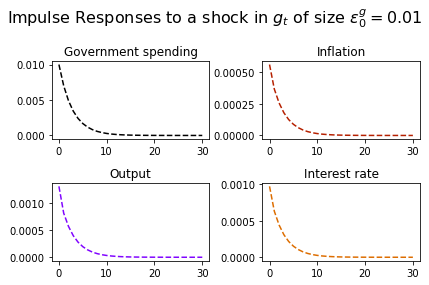

In [17]:
fig, ax = plt.subplots(2,2) # define figure and axis, including the number of rows and columns for the subfigures
cmap = cm.get_cmap('gnuplot') # choose a colormap
# for each axis, define the variable, all in dashed lines, and choose a color from the colormap
ax[0,0].plot(gov_spending, linestyle = 'dashed', color=cmap(0))
ax[0,0].set_title('Government spending') # set title for each subfigure
ax[1,0].plot(output, linestyle = 'dashed', color=cmap(0.25) )
ax[1,0].set_title('Output')
ax[0,1].plot(inflation, linestyle = 'dashed', color=cmap(0.5) )
ax[0,1].set_title('Inflation')
ax[1,1].plot(interest, linestyle = 'dashed', color=cmap(0.75) )
ax[1,1].set_title('Interest rate')
fig.suptitle(f'Impulse Responses to a shock in $g_t$ of size $\epsilon_0^g = {epsg}$', fontsize=16) # title of figure
fig.tight_layout() # makes sure the labels from the figures do not overlap
plt.show() # show the figure

# #6 Interpretation of impulse responses

Generally, the autocorrelation in government spending shapes the agent's expectations such that government spending today affects to expected future government spending.
Looking at the graphs, one first notcies that government spending reacts one-to-one to a shock in government spending in the first period, which it should be by construction, and then steadily decreases to zero. Output reacts positive to a shock in government spending which is not only influenced by the relation of government spending and output but also by how the other variables react to the shock. However, as we see, output is positively influenced which also makes sense intuitively, i.e if consumption (in form of government spending) increases, total output should increase as well. Especially, because of price stickiness output is mainly demand-driven. Next, also inflation reacts positively. A higher demand results in higher prices which raises inflation naturally according to the Phillips curve. Finally, also the interest rate is increased by a shock in government spending. The interest rate, as determined by the Taylor rule, is a function of output and inflation. So when both, output and inflation, are increased, the interest rate should react in the same way. Also, as we set $\phi_{\pi}$ larger than $1$ we ensure that the Taylor principle holds, the nominal interest rates increases more than inflation such that monetary policy can steer the economy, whereby we rule out sunspot equilibria. All in all we should also note that all variables are converging back to their steady state level after around 10 periods such that the impact of a shock in government spending is fading out quite fast.

# #7 Linear Time Iteration: Function

In [18]:
# define a function using the matrices A, M and D as input as well es a first guess an F
def lin_time_iter(A, M, D, Fguess):
    '''
    Performs linear time iteration given the arguments. 
    Returns F and Q.
    '''
    # make a while loop as before until the difference between F and Fnew is small enough
    F = Fguess
    Fnew = np.linalg.inv(A - M @ F) @ D
    while np.max(abs(F - Fnew)) > 1e-10:
        F = Fnew
        Fnew = np.linalg.inv(A - M @ F) @ D
    # save the latest F when the loop stops
    F_final = Fnew
    # Calculate Q
    Q = np.linalg.inv(A - M @ F_final)
    # function return the solution for F and Q
    return F_final, Q

# #8 Define Matrices A, M and D

$ A z_t = M E z_{t+1} + D z_{t-1} + u_t$

In [19]:
A = A # same as before

M = np.array([np.zeros(4),
            [-params['gbar'],1, (1-params['gbar'])/params['sigma'],0],
            [0,0,params['beta'],0],
            np.zeros(4)])

D = np.zeros((4,4))
D[0,0] = params['rho_g']

# guess a 4x4 matrix
F_init = np.random.randn(4,4)

# call the function and save results F and Q
F, Q = lin_time_iter(A=A, M=M, D=D, Fguess=F_init)

In [22]:
print(F[:,0]) # should be equal to cg
print(Q[:,0]) # should be equal to ce

[0.7        0.08116102 0.03677436 0.06327765]
[1.         0.11594431 0.0525348  0.09039664]


# #9 Interpretation of $F$ and $Q$

We should first note that the first columns of $F$ and $Q$ are similar in the way that their elements have the same ratios, i.e. the second element in $F$ is $0.7$ times the second element in $Q$ and so on. The first column of $F$ tells us how $z_t$ reacts to a change in $g_{t-1}$. The first column of $Q$ shows the reaction of $z_t$ to a shock in government spending, the second column would show the reaction to a shock in output and so on. Similarly, the vectors $C_g$ and $C_{\epsilon g}$ show those reactions and are the same as the first columns of $F$ and $Q$, respectively.